In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Bidirectional, GRU
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/DataForModel.zip"
extract_path = "/content/DataForModel"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete. Files are in:", extract_path)


Extraction complete. Files are in: /content/DataForModel


In [ ]:
df=pd.read_csv("preprocessed.csv")

In [ ]:
df.head()

,aspect,burned_areas,curvature,d2m,dem,ignition_points,ndvi,rh,roads_distance,slope,...,month,day,day_of_year,week_of_year,quarter,month_sin,month_cos,day_of_year_sin,day_of_year_cos,target
0,-0.023376,-0.087595,-0.152924,0.749859,-1.210648,-0.011168,-1.306742,-0.838179,-0.457263,-0.322125,...,7,29,210,30,3,-0.500000,-0.866025,-0.455907,-0.890028,1
1,-0.023376,-0.087595,-0.152924,0.806068,-1.210648,-0.011168,-1.306742,-0.837083,-0.457263,-0.322125,...,7,30,211,30,3,-0.500000,-0.866025,-0.471160,-0.882048,1
2,-0.023376,-0.087595,-0.152924,0.822762,-1.210648,-0.011168,-1.306742,-0.395334,-0.457263,-0.322125,...,7,31,212,31,3,-0.500000,-0.866025,-0.486273,-0.873807,1
3,-0.023376,-0.087595,-0.152924,0.828469,-1.210648,-0.011168,-1.306742,-0.649035,-0.457263,-0.322125,...,8,1,213,31,3,-0.866025,-0.500000,-0.501242,-0.865307,1
4,-0.023376,-0.087595,-0.152924,0.854087,-1.210648,-0.011168,-1.306742,-0.260139,-0.457263,-0.322125,...,8,2,214,31,3,-0.866025,-0.500000,-0.516062,-0.856551,1


**Model Implementation and Evaluation**

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
df = df.sort_values(["year", "month", "day"])
train_df = df[df["year"].between(2006, 2019)]
val_df = df[df["year"] == 2020]
test_df = df[df["year"].between(2021, 2022)]
def create_time_series(data, target_col, time_steps=30):
    X, y = [], []
    drop_cols = [target_col, "year"]
    total = len(data) - time_steps
    def process_sequence(i):
        if i % 1000 == 0:
            print(f"🔄 Processing sequence {i}/{total}")
        return (
            data.iloc[i : i + time_steps].drop(columns=drop_cols).values,
            data.iloc[i + time_steps][target_col]
        )
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_sequence, i): i for i in range(total)}
        for future in as_completed(futures):
            try:
                result = future.result()
                X.append(result[0])
                y.append(result[1])
            except Exception as e:
                print(f"⚠️ Error processing sequence {futures[future]}: {e}")
    print("✅ Time-series processing completed!")
    return np.array(X), np.array(y)
X_train, y_train = create_time_series(train_df, "target", 30)
X_val, y_val = create_time_series(val_df, "target", 30)
X_test, y_test = create_time_series(test_df, "target", 30)
os.makedirs("DataForModel", exist_ok=True)
np.save("DataForModel/X_train.npy", X_train)
np.save("DataForModel/y_train.npy", y_train)
np.save("DataForModel/X_val.npy", X_val)
np.save("DataForModel/y_val.npy", y_val)
np.save("DataForModel/X_test.npy", X_test)
np.save("DataForModel/y_test.npy", y_test)
print("✅ Time-series data saved successfully!")
print("✅ Time-series data saved successfully!")
print(f"Train Shape: {X_train.shape}")
print(f"Val Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")

🔄 Processing sequence 0/584683
🔄 Processing sequence 1000/584683
🔄 Processing sequence 2000/584683
🔄 Processing sequence 3000/584683
🔄 Processing sequence 4000/584683
🔄 Processing sequence 5000/584683
🔄 Processing sequence 6000/584683
🔄 Processing sequence 7000/584683
🔄 Processing sequence 8000/584683
🔄 Processing sequence 9000/584683
🔄 Processing sequence 10000/584683
🔄 Processing sequence 11000/584683
🔄 Processing sequence 12000/584683
🔄 Processing sequence 13000/584683
🔄 Processing sequence 14000/584683
🔄 Processing sequence 15000/584683
🔄 Processing sequence 16000/584683
🔄 Processing sequence 17000/584683
🔄 Processing sequence 18000/584683
🔄 Processing sequence 19000/584683
🔄 Processing sequence 20000/584683
🔄 Processing sequence 21000/584683
🔄 Processing sequence 22000/584683
🔄 Processing sequence 23000/584683
🔄 Processing sequence 24000/584683
🔄 Processing sequence 25000/584683
🔄 Processing sequence 26000/584683
🔄 Processing sequence 27000/584683
🔄 Processing sequence 28000/58468

In [4]:
X_train = np.load("DataForModel/DataForModel/X_train.npy")
y_train = np.load("DataForModel/DataForModel/y_train.npy")
X_val = np.load("DataForModel/DataForModel/X_val.npy")
y_val = np.load("DataForModel/DataForModel/y_val.npy")
X_test = np.load("DataForModel/DataForModel/X_test.npy")
y_test = np.load("DataForModel/DataForModel/y_test.npy")
with open("DataForModel/DataForModel/class_weights.json", "r") as f:
    class_weights = json.load(f)
class_weights = {int(k): v for k, v in class_weights.items()}
print("Class Weights:", class_weights)

Class Weights: {0: 0.7475346174971332, 1: 1.5099597483689136}


In [5]:
# Print data shapes to confirm everything is loaded correctly
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (252461, 30, 43)
X_val shape: (34246, 30, 43)
X_test shape: (59781, 30, 43)
y_train shape: (252461,)
y_val shape: (34246,)
y_test shape: (59781,)


**Models**



In [6]:
# Create model checkpoints directory if it doesn't exist
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

In [7]:
# Positional encoding function for transformer model
def positional_encoding(seq_len=30, d_model=256, dropout=0.1):
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(math.log(10000.0) / d_model))
    pe = tf.zeros([seq_len, 1, d_model], dtype=tf.float32)
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            pe = tf.tensor_scatter_nd_update(
                pe, [[pos, 0, i]], [tf.sin(position[pos] * div_term[i//2])]
            )
            if i+1 < d_model:
                pe = tf.tensor_scatter_nd_update(
                    pe, [[pos, 0, i+1]], [tf.cos(position[pos] * div_term[i//2])]
                )

    pe = tf.Variable(pe, trainable=False)

    def encode(x):
        x = x + pe[:x.shape[0]]
        x = tf.keras.layers.Dropout(dropout)(x)
        return x

    return encode

# Simple LSTM Model from your existing code
def simple_lstm(input_dim=24, output_lstm=128, dropout=0.5):
    inputs = tf.keras.Input(shape=(None, input_dim))
    x = tf.keras.layers.LayerNormalization()(inputs)
    x = tf.keras.layers.LSTM(output_lstm, return_sequences=False)(x)
    x = tf.keras.layers.Dense(output_lstm)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(output_lstm // 2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.ReLU()(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Transformer Model
def transformer_model(seq_len=30, input_dim=24, d_model=256, nhead=8, num_layers=4, dropout=0.1):
    inputs = tf.keras.Input(shape=(None, input_dim))
    x = tf.keras.layers.Dense(d_model)(inputs)

    # Use simpler approach without positional encoding if it causes issues
    for _ in range(num_layers):
        # Self attention
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=nhead, key_dim=d_model//nhead
        )(x, x)
        x = tf.keras.layers.LayerNormalization()(x + attention_output)

        # Feed forward
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_model*4, activation="relu"),
            tf.keras.layers.Dense(d_model)
        ])
        ffn_output = ffn(x)
        x = tf.keras.layers.LayerNormalization()(x + ffn_output)

    # Global pooling and output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model
# Simple RNN model (replacing Simple NN)
def create_simple_rnn(input_shape):
    """Create a simple RNN model for time series data"""
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.SimpleRNN(128, return_sequences=False)(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Deep RNN model (replacing Deep NN)
def create_deep_rnn(input_shape):
    """Create a deeper RNN model for time series data"""
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.SimpleRNN(128, return_sequences=True)(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.SimpleRNN(64, return_sequences=False)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Bidirectional LSTM model
def create_bidirectional_lstm(input_dim):
    inputs = tf.keras.Input(shape=(None, input_dim))
    x = tf.keras.layers.LayerNormalization()(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [9]:

# Function to train and evaluate models
def train_and_evaluate_model(model, model_name, X_train, X_val, X_test, y_train, y_val, y_test, epochs=10, class_weights=None):
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    print(f"{'='*50}")

    # Define callbacks for early stopping and model checkpointing
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_path = f'model_checkpoints/{model_name}_best.h5'
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=64,
            callbacks=[early_stopping, model_checkpoint],
            class_weight=class_weights,
            verbose=1
        )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate the model on test data
    print(f"\nEvaluating {model_name} on test data...")
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    try:
        roc_auc = roc_auc_score(y_test, y_pred_prob)
    except Exception as e:
        print(f"Warning: Could not calculate ROC AUC - {e}")
        roc_auc = None

    # Print metrics
    print(f"\n{model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Return metrics as dictionary
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if roc_auc is not None else 0
    }


Training Simple Neural Network...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 43)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,337 (118.50 KB)

 Trainable params: 30,337 (118.50 KB)

 Non-trainable params: 0 (0.00 B)


Training SimpleNN...
Epoch 1/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6350 - loss: 0.6311
Epoch 1: val_accuracy improved from -inf to 0.93001, saving model to model_checkpoints/SimpleNN_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.6350 - loss: 0.6311 - val_accuracy: 0.9300 - val_loss: 0.2509
Epoch 2/10
3943/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5682 - loss: 0.6669
Epoch 2: val_accuracy did not improve from 0.93001
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.5682 - loss: 0.6669 - val_accuracy: 0.7229 - val_loss: 0.5693
Epoch 3/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7033 - loss: 0.5720
Epoch 3: val_accuracy did not improve from 0.93001
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7033 - loss: 0.5720 - val_accuracy: 0.9247 - val_loss: 0.3059
Epoch 4/10
3941/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6802 - loss: 0.5796
Epoch 4: val_accuracy did not improve from 0.93001
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.6802 - loss: 0.5795 - val_accuracy: 0.9299 - val_loss: 0.3240
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


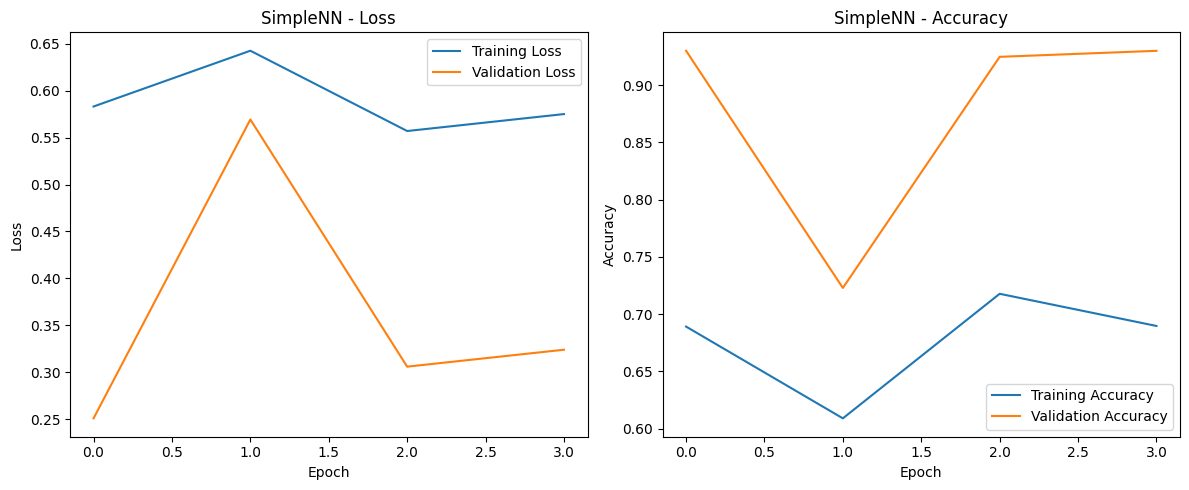


Evaluating SimpleNN on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

SimpleNN Evaluation Results:
Accuracy: 0.9381
Precision: 0.9825
Recall: 0.8693
F1 Score: 0.9224
ROC AUC: 0.9804


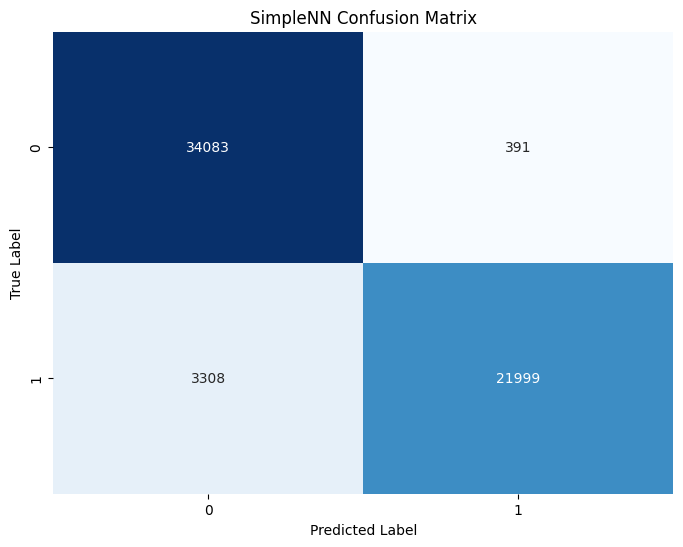

In [10]:

# Initialize list to store results
results = []

# Model 1: Simple Neural Network
print("\nTraining Simple Neural Network...")
model_nn = create_simple_rnn(X_train.shape[1:])
model_nn.summary()
nn_results = train_and_evaluate_model(
    model_nn,
    "SimpleNN",
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    epochs=10,
    class_weights=class_weights
)
results.append(nn_results)



Training LSTM Model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 43)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, None, 43)            │              86 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          88,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,983 (441.34 KB)

 Trainable params: 112,983 (441.34 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM...
Epoch 1/10
3939/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4982 - loss: 0.7034
Epoch 1: val_accuracy improved from -inf to 0.66300, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.4982 - loss: 0.7034 - val_accuracy: 0.6630 - val_loss: 0.6112
Epoch 2/10
3943/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7113 - loss: 0.5669
Epoch 2: val_accuracy improved from 0.66300 to 0.84813, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.7114 - loss: 0.5669 - val_accuracy: 0.8481 - val_loss: 0.3435
Epoch 3/10
3943/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8019 - loss: 0.4403
Epoch 3: val_accuracy improved from 0.84813 to 0.91523, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8019 - loss: 0.4403 - val_accuracy: 0.9152 - val_loss: 0.2090
Epoch 4/10
3940/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8853 - loss: 0.2917
Epoch 4: val_accuracy improved from 0.91523 to 0.92358, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8853 - loss: 0.2916 - val_accuracy: 0.9236 - val_loss: 0.2074
Epoch 5/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9383 - loss: 0.1743
Epoch 5: val_accuracy improved from 0.92358 to 0.94864, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9383 - loss: 0.1743 - val_accuracy: 0.9486 - val_loss: 0.1430
Epoch 6/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9467 - loss: 0.1524
Epoch 6: val_accuracy improved from 0.94864 to 0.95626, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9467 - loss: 0.1524 - val_accuracy: 0.9563 - val_loss: 0.1329
Epoch 7/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9520 - loss: 0.1380
Epoch 7: val_accuracy did not improve from 0.95626
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.9520 - loss: 0.1380 - val_accuracy: 0.9258 - val_loss: 0.1912
Epoch 8/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9570 - loss: 0.1257
Epoch 8: val_accuracy improved from 0.95626 to 0.96508, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.9570 - loss: 0.1257 - val_accuracy: 0.9651 - val_loss: 0.1033
Epoch 9/10
3943/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9605 - loss: 0.1155
Epoch 9: val_accuracy improved from 0.96508 to 0.96575, saving model to model_checkpoints/LSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.9605 - loss: 0.1155 - val_accuracy: 0.9657 - val_loss: 0.1078
Epoch 10/10
3938/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9626 - loss: 0.1086
Epoch 10: val_accuracy did not improve from 0.96575
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9626 - loss: 0.1086 - val_accuracy: 0.9539 - val_loss: 0.1307
Restoring model weights from the end of the best epoch: 9.


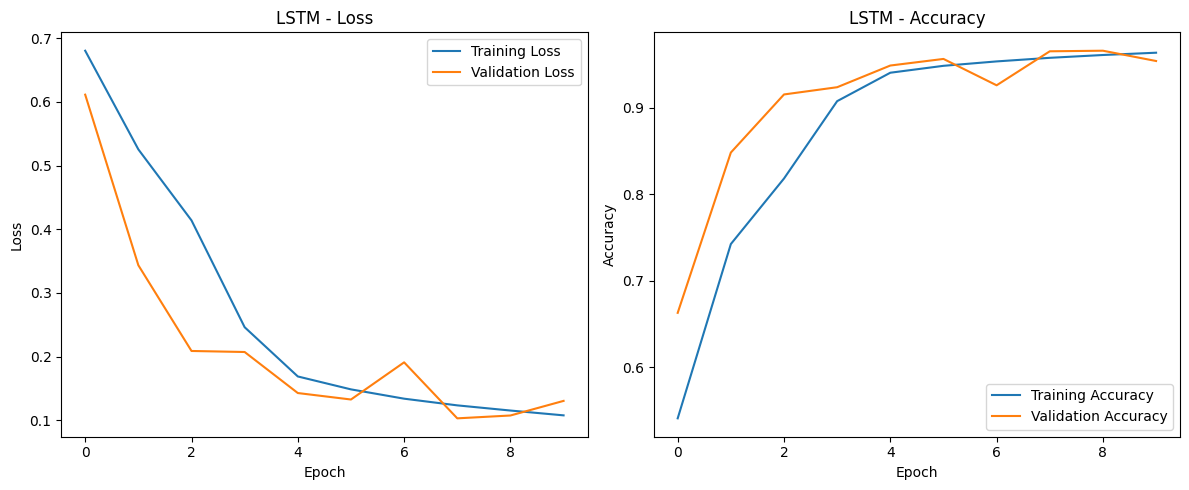


Evaluating LSTM on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

LSTM Evaluation Results:
Accuracy: 0.9726
Precision: 0.9688
Recall: 0.9663
F1 Score: 0.9676
ROC AUC: 0.9942


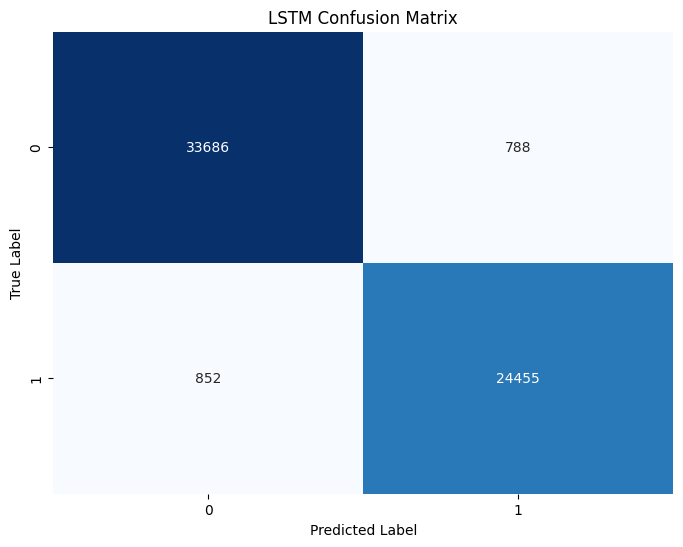

In [11]:

# Model 2: LSTM Model
print("\nTraining LSTM Model...")
model_lstm = simple_lstm(input_dim=X_train.shape[2])
model_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model_lstm.summary()
lstm_results = train_and_evaluate_model(
    model_lstm,
    "LSTM",
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    epochs=10,
    class_weights=class_weights
)
results.append(lstm_results)


Training Transformer Model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, 43)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, None, 128)      │          5,632 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 128)      │         66,048 │ dense_5[0][0],         │
│ (MultiHeadAttention)      │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, None, 128)      │              0 │ dense_5[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, None, 128)      │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, None, 128)      │        131,712 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, None, 128)      │              0 │ layer_normalization_1… │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, None, 128)      │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, None, 128)      │         66,048 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, None, 128)      │              0 │ layer_normalization_2… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, None, 128)      │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, None, 128)      │        131,712 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, None, 128)      │              0 │ layer_normalization_3… │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, None, 128)      │            256 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 402,305 (1.53 MB)

 Trainable params: 402,305 (1.53 MB)

 Non-trainable params: 0 (0.00 B)


Training Transformer...
Epoch 1/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6996 - loss: 0.5314
Epoch 1: val_accuracy improved from -inf to 0.89333, saving model to model_checkpoints/Transformer_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.6996 - loss: 0.5314 - val_accuracy: 0.8933 - val_loss: 0.2691
Epoch 2/10
3938/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8941 - loss: 0.2765
Epoch 2: val_accuracy improved from 0.89333 to 0.92087, saving model to model_checkpoints/Transformer_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8941 - loss: 0.2765 - val_accuracy: 0.9209 - val_loss: 0.2125
Epoch 3/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9136 - loss: 0.2372
Epoch 3: val_accuracy improved from 0.92087 to 0.92957, saving model to model_checkpoints/Transformer_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9136 - loss: 0.2372 - val_accuracy: 0.9296 - val_loss: 0.1826
Epoch 4/10
3938/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9317 - loss: 0.2007
Epoch 4: val_accuracy improved from 0.92957 to 0.94183, saving model to model_checkpoints/Transformer_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9317 - loss: 0.2007 - val_accuracy: 0.9418 - val_loss: 0.1753
Epoch 5/10
3941/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9263 - loss: 0.2092
Epoch 5: val_accuracy did not improve from 0.94183
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9263 - loss: 0.2092 - val_accuracy: 0.9274 - val_loss: 0.2105
Epoch 6/10
3939/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9406 - loss: 0.1805
Epoch 6: val_accuracy improved from 0.94183 to 0.95302, saving model to model_checkpoints/Transformer_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9406 - loss: 0.1805 - val_accuracy: 0.9530 - val_loss: 0.1475
Epoch 7/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9439 - loss: 0.1746
Epoch 7: val_accuracy did not improve from 0.95302
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9439 - loss: 0.1746 - val_accuracy: 0.9518 - val_loss: 0.1450
Epoch 8/10
3938/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9459 - loss: 0.1695
Epoch 8: val_accuracy did not improve from 0.95302
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9459 - loss: 0.1695 - val_accuracy: 0.9483 - val_loss: 0.1455
Epoch 9/10
3937/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9404 - loss: 0.1802
Epoch 9: val_accuracy did not improve from 0.95302
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9404 - loss: 0.1802 - val_accuracy: 0.9506 - val_loss: 0.1408
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


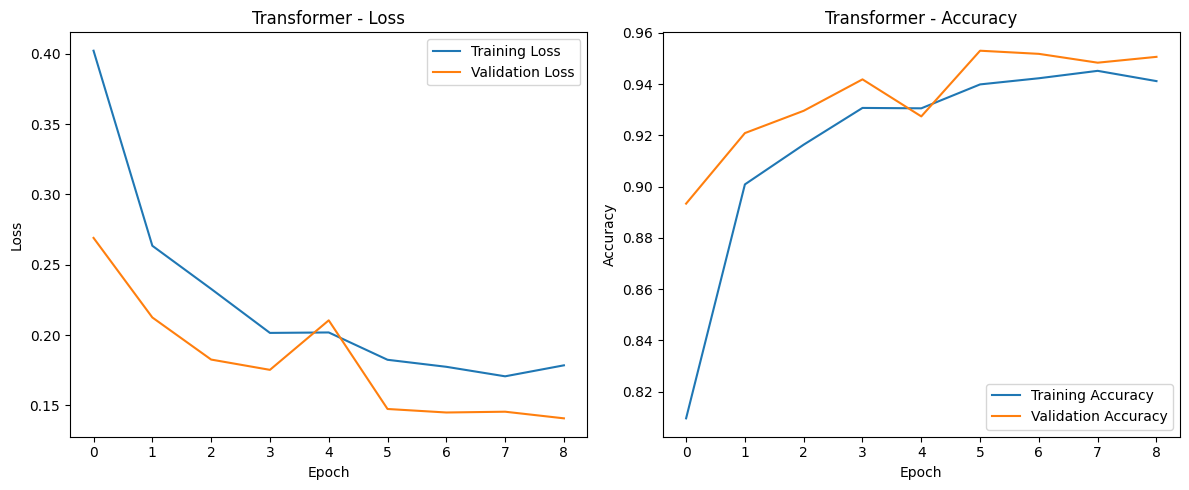


Evaluating Transformer on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Transformer Evaluation Results:
Accuracy: 0.9578
Precision: 0.9823
Recall: 0.9169
F1 Score: 0.9485
ROC AUC: 0.9867


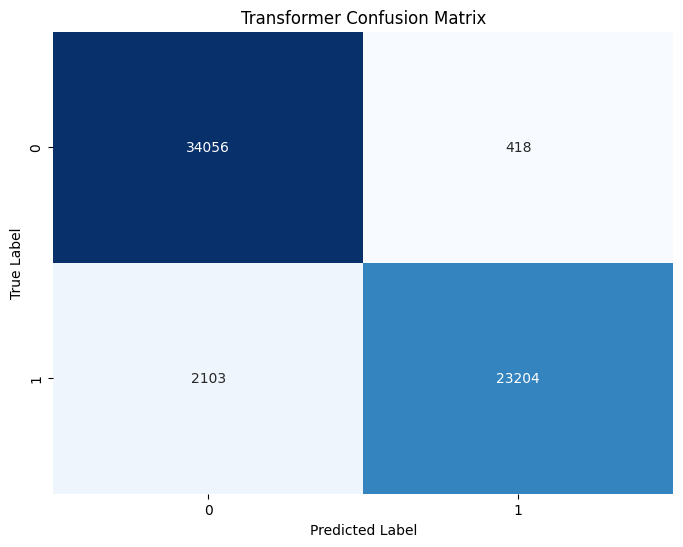

In [13]:

try:
    print("\nTraining Transformer Model...")
    seq_len = X_train.shape[1] # Get sequence length from data
    model_transformer = transformer_model(
        seq_len=seq_len,
        input_dim=X_train.shape[2],
        d_model=128,
        nhead=4,
        num_layers=2
    )
    model_transformer.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    model_transformer.summary()
    transformer_results = train_and_evaluate_model(
        model_transformer,
        "Transformer",
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        epochs=10,
        class_weights=class_weights
    )
    results.append(transformer_results)
except Exception as e:
    print(f"Error with transformer model: {e}")
    print("Skipping transformer model...")


Training Deep Neural Network...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 30, 43)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30, 128)             │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,481 (142.50 KB)

 Trainable params: 36,481 (142.50 KB)

 Non-trainable params: 0 (0.00 B)


Training DeepNN...
Epoch 1/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6146 - loss: 0.6534
Epoch 1: val_accuracy improved from -inf to 0.62737, saving model to model_checkpoints/DeepNN_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.6146 - loss: 0.6534 - val_accuracy: 0.6274 - val_loss: 0.6681
Epoch 2/10
3939/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7029 - loss: 0.5930
Epoch 2: val_accuracy did not improve from 0.62737
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7029 - loss: 0.5930 - val_accuracy: 0.5770 - val_loss: 0.6913
Epoch 3/10
3941/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5847 - loss: 0.6590
Epoch 3: val_accuracy did not improve from 0.62737
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.5847 - loss: 0.6590 - val_accuracy: 0.6264 - val_loss: 0.6429
Epoch 4/10
3941/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5967 - loss: 0.6521
Epoch 4: val_accuracy did not improve from 0.62737
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.5967 - loss: 0.6521 - val_accuracy: 0.6169 - val_loss: 0.6502
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


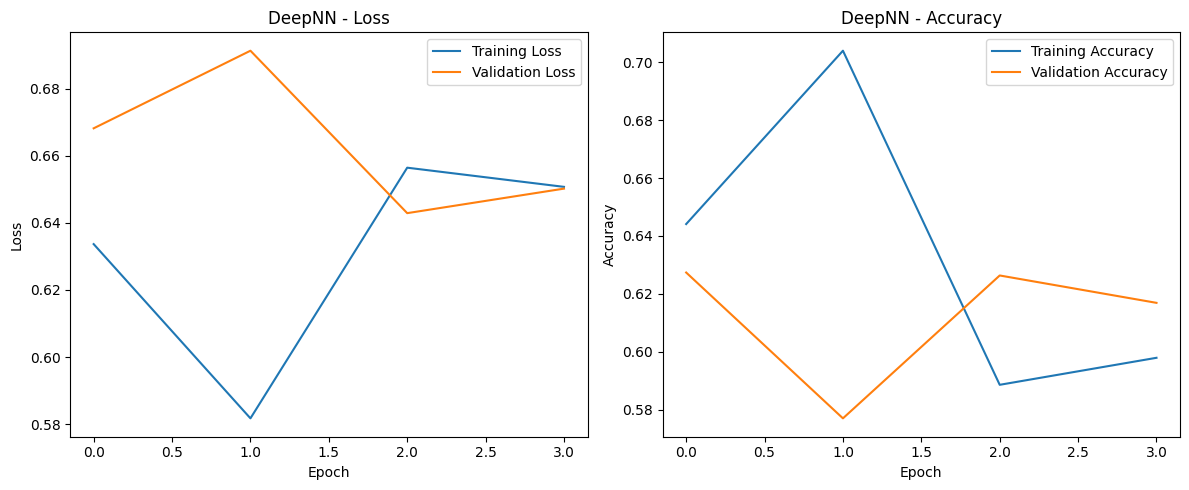


Evaluating DeepNN on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

DeepNN Evaluation Results:
Accuracy: 0.6191
Precision: 0.5330
Recall: 0.8089
F1 Score: 0.6426
ROC AUC: 0.6271


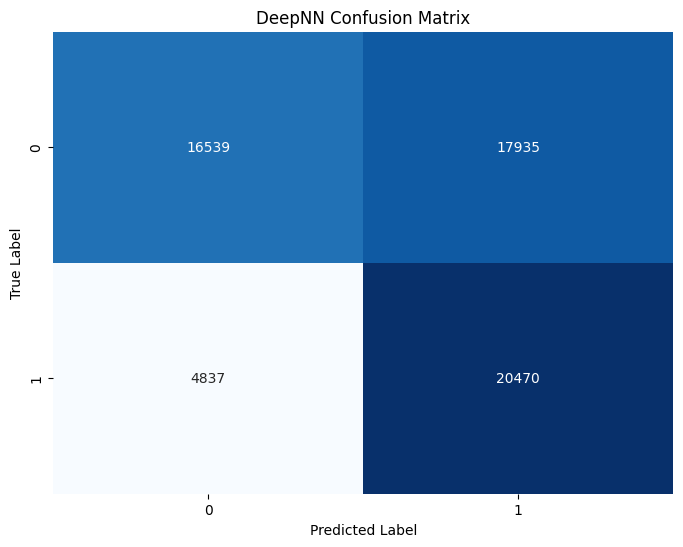

In [14]:

# Model 4: Deep Neural Network
print("\nTraining Deep Neural Network...")
model_deep_nn = create_deep_rnn(X_train.shape[1:])
model_deep_nn.summary()
deep_nn_results = train_and_evaluate_model(
    model_deep_nn,
    "DeepNN",
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    epochs=10,
    class_weights=class_weights
)
results.append(deep_nn_results)


Training Bidirectional LSTM...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, None, 43)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ (None, None, 43)            │              86 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 128)           │          55,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,655 (381.46 KB)

 Trainable params: 97,655 (381.46 KB)

 Non-trainable params: 0 (0.00 B)


Training BidirectionalLSTM...
Epoch 1/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5021 - loss: 0.6979
Epoch 1: val_accuracy improved from -inf to 0.48496, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 60s 14ms/step - accuracy: 0.5021 - loss: 0.6979 - val_accuracy: 0.4850 - val_loss: 0.7285
Epoch 2/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5688 - loss: 0.6635
Epoch 2: val_accuracy improved from 0.48496 to 0.78625, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.5688 - loss: 0.6635 - val_accuracy: 0.7863 - val_loss: 0.4884
Epoch 3/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7394 - loss: 0.5258
Epoch 3: val_accuracy improved from 0.78625 to 0.86807, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.7394 - loss: 0.5258 - val_accuracy: 0.8681 - val_loss: 0.3399
Epoch 4/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8058 - loss: 0.4315
Epoch 4: val_accuracy improved from 0.86807 to 0.91628, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.8058 - loss: 0.4315 - val_accuracy: 0.9163 - val_loss: 0.2506
Epoch 5/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8476 - loss: 0.3589
Epoch 5: val_accuracy improved from 0.91628 to 0.95261, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.8476 - loss: 0.3589 - val_accuracy: 0.9526 - val_loss: 0.1761
Epoch 6/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8853 - loss: 0.2885
Epoch 6: val_accuracy did not improve from 0.95261
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - accuracy: 0.8853 - loss: 0.2885 - val_accuracy: 0.9414 - val_loss: 0.1646
Epoch 7/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9273 - loss: 0.1900
Epoch 7: val_accuracy improved from 0.95261 to 0.95804, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - accuracy: 0.9273 - loss: 0.1900 - val_accuracy: 0.9580 - val_loss: 0.1254
Epoch 8/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9419 - loss: 0.1571
Epoch 8: val_accuracy did not improve from 0.95804
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - accuracy: 0.9419 - loss: 0.1571 - val_accuracy: 0.9204 - val_loss: 0.2948
Epoch 9/10
3941/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9463 - loss: 0.1445
Epoch 9: val_accuracy improved from 0.95804 to 0.95918, saving model to model_checkpoints/BidirectionalLSTM_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 55s 14ms/step - accuracy: 0.9463 - loss: 0.1445 - val_accuracy: 0.9592 - val_loss: 0.1164
Epoch 10/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9516 - loss: 0.1329
Epoch 10: val_accuracy did not improve from 0.95918
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.9516 - loss: 0.1329 - val_accuracy: 0.9532 - val_loss: 0.1300
Restoring model weights from the end of the best epoch: 9.


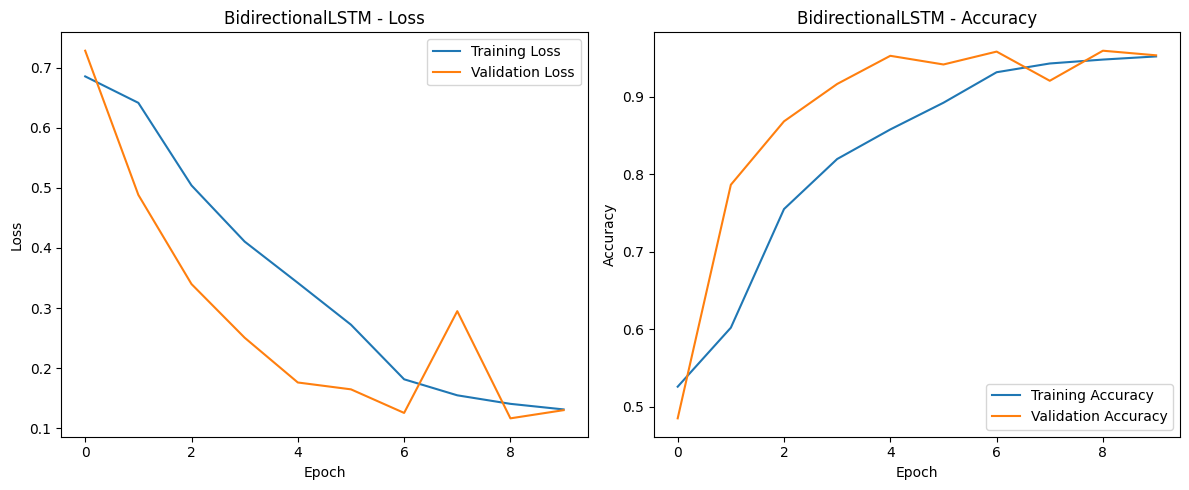


Evaluating BidirectionalLSTM on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

BidirectionalLSTM Evaluation Results:
Accuracy: 0.9678
Precision: 0.9722
Recall: 0.9511
F1 Score: 0.9615
ROC AUC: 0.9916


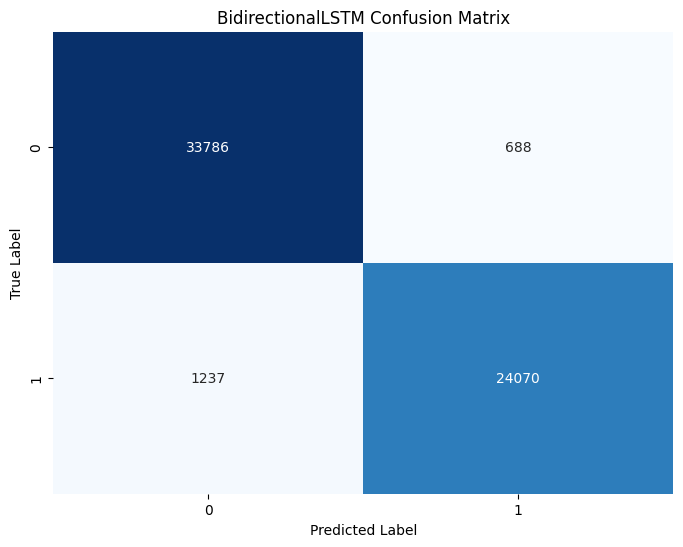

In [15]:

# Model 5: Bidirectional LSTM
print("\nTraining Bidirectional LSTM...")
model_bilstm = create_bidirectional_lstm(X_train.shape[2])
model_bilstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model_bilstm.summary()
bilstm_results = train_and_evaluate_model(
    model_bilstm,
    "BidirectionalLSTM",
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    epochs=10,
    class_weights=class_weights
)
results.append(bilstm_results)


Model Performance Comparison:
                   Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                               
SimpleNN           0.938124   0.982537  0.869285  0.922448  0.980443
LSTM               0.972567   0.968783  0.966333  0.967557  0.994184
Transformer        0.957829   0.982305  0.916900  0.948476  0.986676
DeepNN             0.619076   0.533004  0.808867  0.642579  0.627126
BidirectionalLSTM  0.967799   0.972211  0.951120  0.961550  0.991609


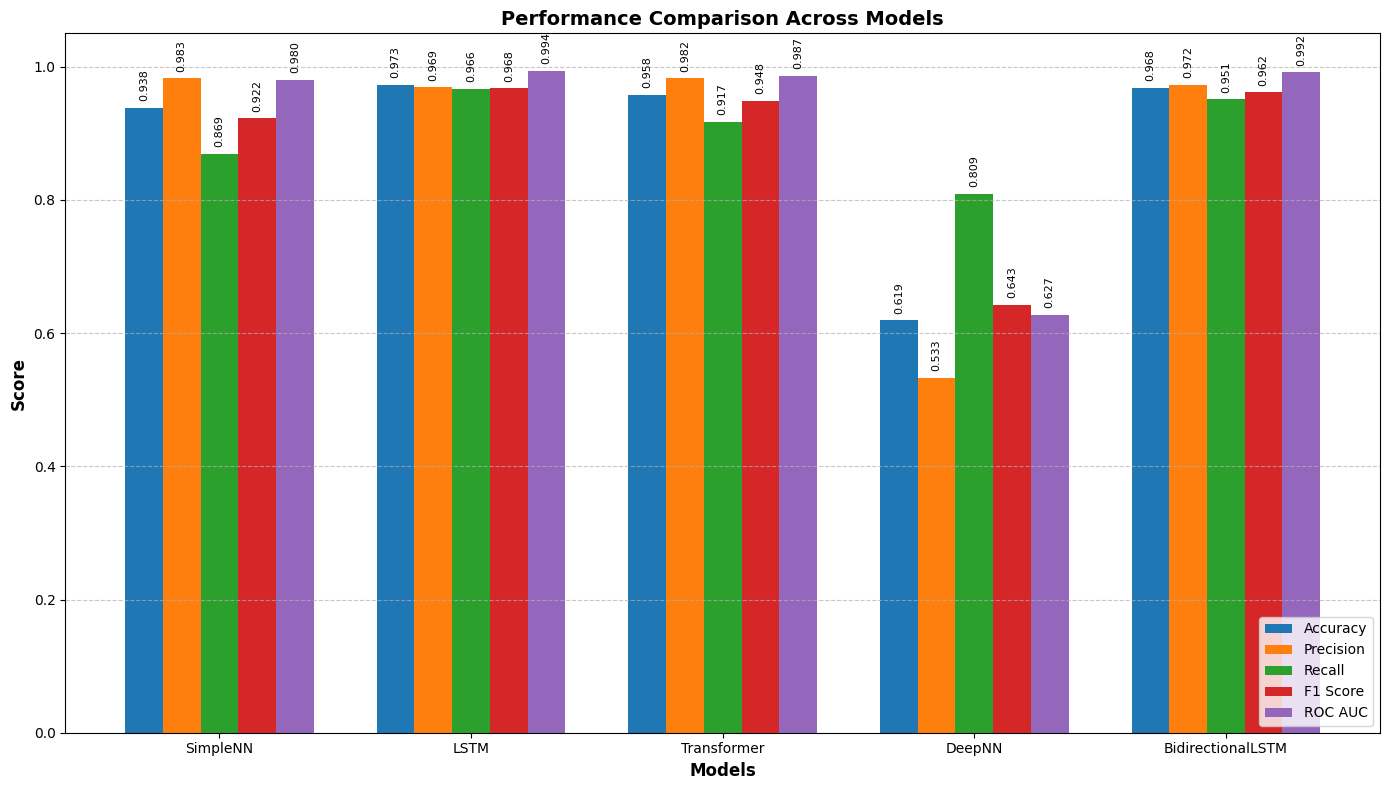

In [16]:

# Compare model results
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1'],
        'ROC AUC': r['roc_auc']
    } for r in results
])

# Display results table
print("\nModel Performance Comparison:")
results_df_display = results_df.copy()
results_df_display.set_index('Model', inplace=True)
print(results_df_display)

# Visualize model comparison
plt.figure(figsize=(14, 8))

# Plot bar chart for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
x = np.arange(len(results_df['Model']))
width = 0.15
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    bars = plt.bar(x + offset, results_df[metric], width, label=metric)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

    multiplier += 1

plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Performance Comparison Across Models', fontsize=14, fontweight='bold')
plt.xticks(x + width * 2, results_df['Model'])
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [18]:

# Function to run all models on new data
def run_all_models(new_data):
    """
    Run all trained models on new data

    Args:
        new_data: Preprocessed data in the same format as training data

    Returns:
        Dictionary with predictions from each model
    """
    predictions = {}

    # Load and run all models
    model_paths = {
        'SimpleNN': 'model_checkpoints/SimpleNN_best.h5',
        'LSTM': 'model_checkpoints/LSTM_best.h5',
        'Transformer': 'model_checkpoints/Transformer_best.h5',
        'DeepNN': 'model_checkpoints/DeepNN_best.h5',
        'BidirectionalLSTM': 'model_checkpoints/BidirectionalLSTM_best.h5'
    }

    for model_name, model_path in model_paths.items():
        try:
            if os.path.exists(model_path):
                print(f"Loading {model_name} from {model_path}...")
                model = tf.keras.models.load_model(model_path)
                pred = model.predict(new_data)
                predictions[model_name] = (pred > 0.5).astype(int)
                print(f"Successfully ran {model_name}")
            else:
                print(f"Model file not found: {model_path}")
        except Exception as e:
            print(f"Error with {model_name}: {e}")

    return predictions

# Show example of running all models on sample data
print("\nDemonstrating model prediction on sample data...")
sample_data = X_test[0:100]  # Take 5 samples from test data
print(f"Sample data shape: {sample_data.shape}")

predictions = run_all_models(sample_data)
print("\nPredictions from all models:")
for model_name, preds in predictions.items():
    print(f"{model_name} predictions: {preds.flatten()}")

print(f"Actual values: {y_test[0:100]}")

print("\nDone! All models have been trained, evaluated, and saved.")


Demonstrating model prediction on sample data...
Sample data shape: (100, 30, 43)
Loading SimpleNN from model_checkpoints/SimpleNN_best.h5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
Successfully ran SimpleNN
Loading LSTM from model_checkpoints/LSTM_best.h5...


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Successfully ran LSTM
Loading Transformer from model_checkpoints/Transformer_best.h5...
Error with Transformer: too many positional arguments
Loading DeepNN from model_checkpoints/DeepNN_best.h5...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
Successfully ran DeepNN
Loading BidirectionalLSTM from model_checkpoints/BidirectionalLSTM_best.h5...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Successfully ran BidirectionalLSTM

Predictions from all models:
SimpleNN predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
LSTM predictions: [0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DeepNN predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BidirectionalLSTM predictions: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 

# **Hyper Paremter Tuning**

Choosing this LSTM for hyperparameter tuning because it have the best statistics

**Grid Search**

In [21]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


Trial 10 Complete [00h 06m 07s]
val_accuracy: 0.7677977085113525

Best val_accuracy So Far: 0.9739239811897278
Total elapsed time: 00h 58m 27s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🔹 Best Hyperparameters: {'output_lstm': 64, 'dropout': 0.4, 'learning_rate': 0.01}
✅ Best model saved at: /content/model_checkpoints/HyparemeterTuning/best_lstm_model.h5

Training LSTM (Grid Search)...
Epoch 1/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9058 - loss: 0.2096
Epoch 1: val_accuracy improved from -inf to 0.91838, saving model to model_checkpoints/LSTM (Grid Search)_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9058 - loss: 0.2096 - val_accuracy: 0.9184 - val_loss: 0.2887
Epoch 2/10
3941/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8611 - loss: 0.3501
Epoch 2: val_accuracy improved from 0.91838 to 0.93258, saving model to model_checkpoints/LSTM (Grid Search)_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.8611 - loss: 0.3501 - val_accuracy: 0.9326 - val_loss: 0.2085
Epoch 3/10
3940/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5238 - loss: 0.6784
Epoch 3: val_accuracy did not improve from 0.93258
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.5238 - loss: 0.6784 - val_accuracy: 0.4442 - val_loss: 0.7541
Epoch 4/10
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4702 - loss: 0.7066
Epoch 4: val_accuracy did not improve from 0.93258
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.4702 - loss: 0.7066 - val_accuracy: 0.6500 - val_loss: 0.6134
Epoch 5/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5351 - loss: 0.6796
Epoch 5: val_accuracy did not improve from 0.93258
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.5351 - loss: 0.6796 - val_accuracy: 0.4435 - val_loss: 0.7430
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


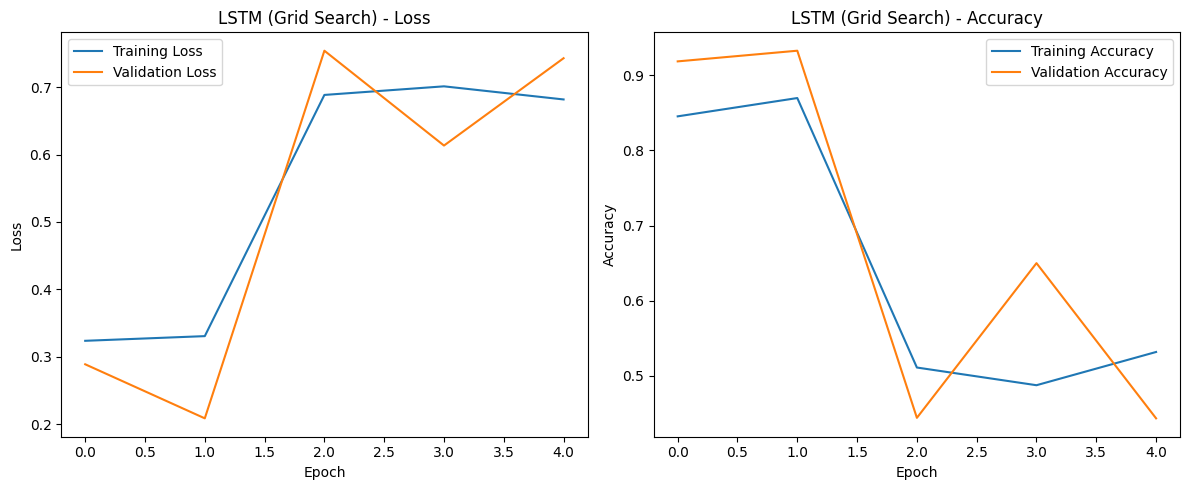


Evaluating LSTM (Grid Search) on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

LSTM (Grid Search) Evaluation Results:
Accuracy: 0.9360
Precision: 0.9041
Recall: 0.9494
F1 Score: 0.9262
ROC AUC: 0.9820


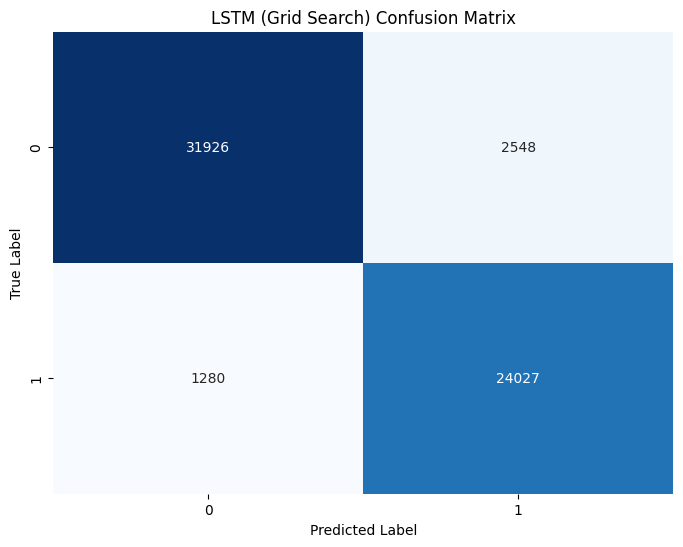

1869/1869 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9700 - loss: 0.1112

✅ Best Model Test Accuracy: 0.9756


In [23]:
from keras_tuner import GridSearch
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_lstm_model(hp):
    input_dim = X_train.shape[2]  # Automatically adjust input dimension
    output_lstm = hp.Choice('output_lstm', values=[64, 128, 256])
    dropout = hp.Choice('dropout', values=[0.3, 0.4, 0.5, 0.6])
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

    inputs = tf.keras.Input(shape=(None, input_dim))
    x = tf.keras.layers.LayerNormalization()(inputs)
    x = tf.keras.layers.LSTM(output_lstm, return_sequences=False)(x)
    x = tf.keras.layers.Dense(output_lstm)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(output_lstm // 2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.ReLU()(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Set up Grid Search
tuner = GridSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='grid_search',
    project_name='lstm_tuning'
)

# Callbacks to save best model
best_model_path = "/content/model_checkpoints/HyparemeterTuning/best_lstm_model.h5"
model_checkpoint = ModelCheckpoint(
    best_model_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Perform the search
with tf.device('/GPU:0'):
    tuner.search(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True), model_checkpoint]
    )

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\n🔹 Best Hyperparameters: {best_hyperparameters.values}")

# Explicitly save the best model
best_model.save(best_model_path)
print(f"✅ Best model saved at: {best_model_path}")

# Train and evaluate the best model
grid_search_results = train_and_evaluate_model(
    best_model,
    "LSTM (Grid Search)",
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    epochs=10,
    class_weights=class_weights
)

# Load best saved model
best_model = tf.keras.models.load_model(best_model_path)
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\n✅ Best Model Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🔹 Best Hyperparameters: {'output_lstm': 64, 'dropout': 0.4, 'learning_rate': 0.01}
✅ Best model saved at: /content/model_checkpoints/HyparemeterTuning/best_lstm_model.h5

Training LSTM (Grid Search)...
Epoch 1/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9465 - loss: 0.1442
Epoch 1: val_accuracy improved from -inf to 0.92855, saving model to model_checkpoints/LSTM (Grid Search)_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.9465 - loss: 0.1443 - val_accuracy: 0.9285 - val_loss: 0.2732
Epoch 2/10
3943/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8075 - loss: 0.4142
Epoch 2: val_accuracy improved from 0.92855 to 0.95722, saving model to model_checkpoints/LSTM (Grid Search)_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.8076 - loss: 0.4142 - val_accuracy: 0.9572 - val_loss: 0.1521
Epoch 3/10
3943/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9141 - loss: 0.2407
Epoch 3: val_accuracy improved from 0.95722 to 0.97465, saving model to model_checkpoints/LSTM (Grid Search)_best.h5


3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9141 - loss: 0.2406 - val_accuracy: 0.9747 - val_loss: 0.1067
Epoch 4/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9348 - loss: 0.1854
Epoch 4: val_accuracy did not improve from 0.97465
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9348 - loss: 0.1854 - val_accuracy: 0.9671 - val_loss: 0.1157
Epoch 5/10
3942/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8999 - loss: 0.2506
Epoch 5: val_accuracy did not improve from 0.97465
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.8999 - loss: 0.2506 - val_accuracy: 0.9700 - val_loss: 0.1060
Epoch 6/10
3944/3945 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9381 - loss: 0.1838
Epoch 6: val_accuracy did not improve from 0.97465
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9381 - loss: 0.1838 - val_accuracy: 0.9669 - val_loss: 0.1209
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


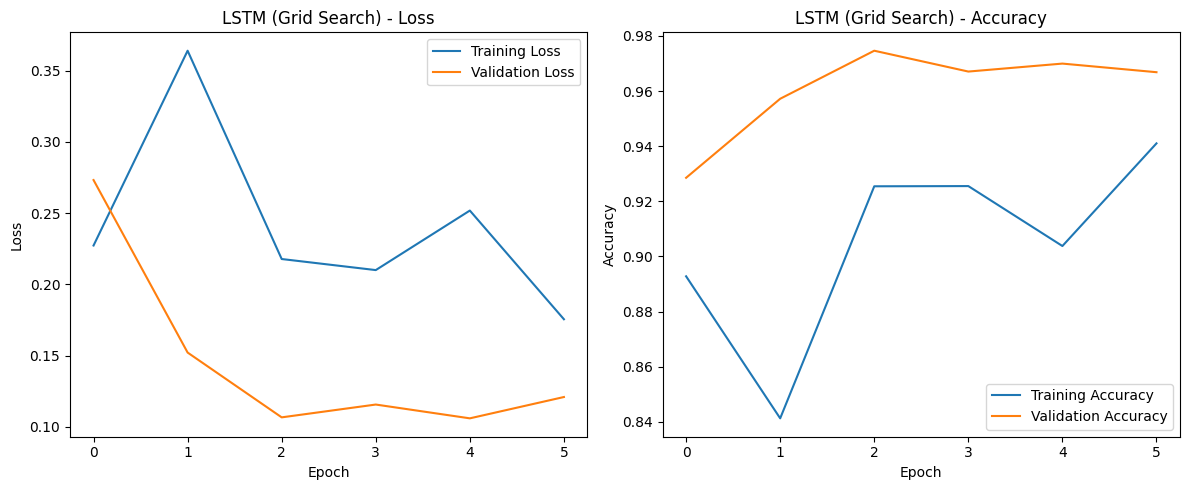


Evaluating LSTM (Grid Search) on test data...
1869/1869 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

LSTM (Grid Search) Evaluation Results:
Accuracy: 0.9713
Precision: 0.9766
Recall: 0.9551
F1 Score: 0.9657
ROC AUC: 0.9915


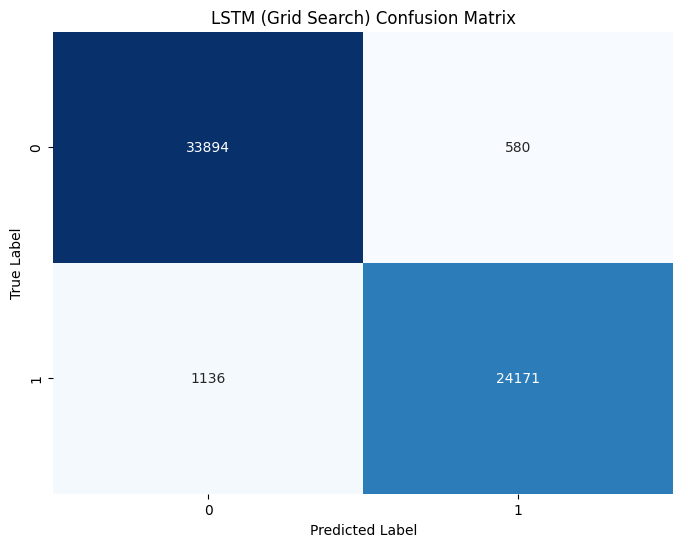

1869/1869 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9700 - loss: 0.1112

✅ Best Model Test Accuracy: 0.9756


In [24]:

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\n🔹 Best Hyperparameters: {best_hyperparameters.values}")

# Explicitly save the best model
best_model.save(best_model_path)
print(f"✅ Best model saved at: {best_model_path}")

# Train and evaluate the best model
grid_search_results = train_and_evaluate_model(
    best_model,
    "LSTM (Grid Search)",
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    epochs=10,
    class_weights=class_weights
)

# Load best saved model
best_model = tf.keras.models.load_model(best_model_path)
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\n✅ Best Model Test Accuracy: {test_acc:.4f}")

In [25]:
grid_search_results

{'model_name': 'LSTM (Grid Search)',
 'accuracy': 0.9712952275806694,
 'precision': 0.9765666033695608,
 'recall': 0.9551112340459161,
 'f1': 0.9657197650725159,
 'roc_auc': np.float64(0.9915251605452416)}

In [38]:

# Compare model results
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1'],
        'ROC AUC': r['roc_auc']
    } for r in results
])

In [39]:
# ... (your existing code) ...

# Rename columns of grid_search_results
grid_search_results = pd.DataFrame([grid_search_results])  # Convert to DataFrame
grid_search_results = grid_search_results.rename(columns={
    'model_name': 'Model',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1 Score',
    'roc_auc': 'ROC AUC'
})

# Concatenate DataFrames
results_df = pd.concat([results_df, grid_search_results], ignore_index=True)

# ... (rest of your code) ...

In [47]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SimpleNN,0.938124,0.982537,0.869285,0.922448,0.980443
1,LSTM,0.972567,0.968783,0.966333,0.967557,0.994184
2,Transformer,0.957829,0.982305,0.916900,0.948476,0.986676
3,DeepNN,0.619076,0.533004,0.808867,0.642579,0.627126
4,BidirectionalLSTM,0.967799,0.972211,0.951120,0.961550,0.991609
5,LSTM (Grid Search),0.971295,0.976567,0.955111,0.965720,0.991525


In [48]:
import plotly.express as px
import plotly.graph_objects as go

# Create a grouped bar plot
fig = go.Figure()

# Define metrics and colors
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Add bars for each metric
for i, metric in enumerate(metrics):
    fig.add_trace(go.Bar(
        x=results_df['Model'],
        y=results_df[metric],
        name=metric,
        text=results_df[metric].round(4),  # Display values on bars
        textposition='auto',  # Automatically position text
        marker_color=colors[i]  # Custom color
    ))

# Update layout for better visualization
fig.update_layout(
    title='Model Performance Comparison Across All Metrics',
    xaxis_title='Model',
    yaxis_title='Score',
    template='plotly_white',  # Clean and professional theme
    hovermode='x unified',  # Show hover information for all bars
    yaxis=dict(range=[0, 1.1]),  # Set y-axis range to emphasize differences
    barmode='group',  # Grouped bars
    legend_title='Metric',
    font=dict(size=14)
)

# Update text position and format
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')

# Show the plot
fig.show()

In [57]:
import plotly.graph_objects as go

# Filter results_df for LSTM and LSTM (Grid Search)
filtered_results_df = results_df[results_df['Model'].isin(['LSTM', 'LSTM (Grid Search)'])]

# Define metrics and neon colors for a high-contrast, premium look
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#00FFFF', '#FF1493', '#32CD32', '#FF8C00', '#FFD700']  # Neon colors for an eye-catching design

# Create a figure
fig = go.Figure()

# Add bars for each metric with an enhanced interactive experience
for i, metric in enumerate(metrics):
    fig.add_trace(go.Bar(
        x=filtered_results_df['Model'],
        y=filtered_results_df[metric],
        name=metric,
        text=[f"{val:.4f}" for val in filtered_results_df[metric]],
        textposition='outside',
        marker=dict(color=colors[i], line=dict(color='white', width=2.5)),  # Strong contrast with a clean outline
        hovertemplate=(
            f'<b>{metric}</b><br>'
            'Model: %{x}<br>'
            'Score: %{y:.4f}<extra></extra>'
        )
    ))

# Update layout for a world-class, futuristic design
fig.update_layout(
    title=dict(
        text='🚀 LSTM Model Performance: Standard vs. Grid Search 🔥',
        x=0.5,
        font=dict(size=28, color='#FFD700', family='Arial Black')  # Gold title for premium impact
    ),
    xaxis_title='<b>Model</b>',
    yaxis_title='<b>Performance Score</b>',
    template='plotly_dark',
    hovermode='x unified',
    yaxis=dict(
        range=[0, 1.1],
        gridcolor='rgba(255,255,255,0.2)',
        tickfont=dict(size=14, color='#FFFFFF'),
        showline=True,
        linewidth=1.5,
        linecolor='white'
    ),
    xaxis=dict(
        tickfont=dict(size=14, color='#FFFFFF'),
        showline=True,
        linewidth=1.5,
        linecolor='white'
    ),
    barmode='group',
    legend=dict(
        title='<b>Performance Metrics</b>',
        font=dict(size=15, color='#00FFFF'),  # Cool cyan color for a striking contrast
        bgcolor='rgba(0,0,0,0.5)',
        bordercolor='white',
        borderwidth=1.5
    ),
    font=dict(size=16, family='Arial', color='white'),
    plot_bgcolor='black',
    paper_bgcolor='black',
    margin=dict(l=80, r=80, t=80, b=80),  # Balanced margins for a cleaner look
    bargap=0.25,  # Optimized bar spacing for readability
)

# Show the enhanced plot
fig.show()
